In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sionna
import scipy
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#fc = 8 GHz
#BW = 20 MHz
#lambda/2 antenna spacing
#channel model: ray tracing
#antenna configuration: UPA
#Tx and Rx 50-element antenna array (10 x 5 UPA)

FC = 8e9
BW = 20e6
D_BY_LAMBDA = 0.5
N_TX = 50
N_RX = 50
N_ROWS = 10
N_COLS = 5
PI = np.pi

def find_thresh(arr, N):

    if N <= 0:
        return np.max(arr) + 1
    if N >= arr.size:
        return np.min(arr)
    
    sorted_arr = np.sort(arr)[::-1]
    threshold = sorted_arr[N-1]
    
    return threshold

In [3]:
scene = sionna.rt.load_scene(sionna.rt.scene.etoile)
scene.frequency = FC

In [4]:
scene.tx_array = sionna.rt.PlanarArray(num_rows=N_ROWS,
                             num_cols=N_COLS,
                             vertical_spacing=D_BY_LAMBDA,
                             horizontal_spacing=D_BY_LAMBDA,
                             pattern="tr38901",
                             polarization="V")

scene.rx_array = sionna.rt.PlanarArray(num_rows=N_ROWS,
                             num_cols=N_COLS,
                             vertical_spacing=D_BY_LAMBDA,
                             horizontal_spacing=D_BY_LAMBDA,
                             pattern="tr38901",
                             polarization="V")

TX_LOC = [41,4,19]
# RX_LOC = [-291,-12,15]
RX_LOC = [-291,60, 3]

tx = sionna.rt.Transmitter(name="tx",
                 position=TX_LOC,
                 display_radius=2)

scene.add(tx)

rx = sionna.rt.Receiver(name="rx",
              position=RX_LOC,
              display_radius=2)

scene.add(rx)

tx.look_at(rx)

# scene.preview()

In [5]:
p_solver  = sionna.rt.PathSolver()

# Compute propagation paths
paths = p_solver(scene=scene,
                 max_depth=7,
                 los=True,
                 specular_reflection=True,
                 diffuse_reflection=False,
                 refraction=True,
                 synthetic_array=True,
                 seed=41)

scene.preview(paths=paths, clip_at=20)

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

Shape of h_freq:  (1, 50, 1, 50, 1, 1000)


Text(0.5, 1.0, 'Channel Frequency Response')

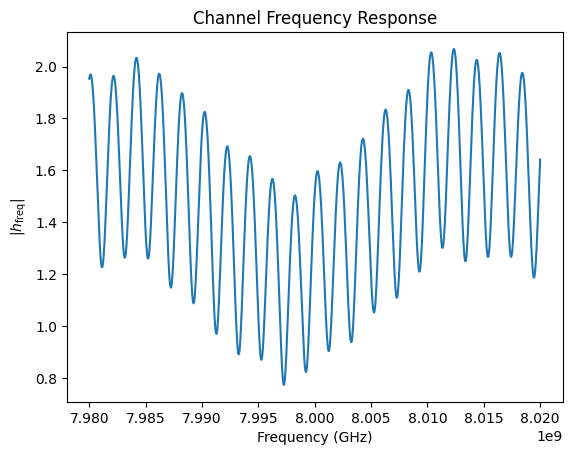

In [6]:
nfreqs = 1000
sweep_freqs = np.linspace(FC-BW, FC+BW, num=nfreqs)
h_freq_sweep = paths.cfr(frequencies=sweep_freqs,
                   normalize=True, # Normalize energy
                   normalize_delays=True,
                   out_type="numpy")

# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_time_steps, num_subcarriers]
print("Shape of h_freq: ", h_freq_sweep.shape)
plt.figure()
plt.plot(sweep_freqs, np.abs(h_freq_sweep)[0,0,0,0,0,:])
plt.xlabel("Frequency (GHz)")
plt.ylabel(r"|$h_\text{freq}$|")
plt.title("Channel Frequency Response")

Shape of h_freq_FC:  (1, 50, 1, 50, 1, 1)
1.6280288


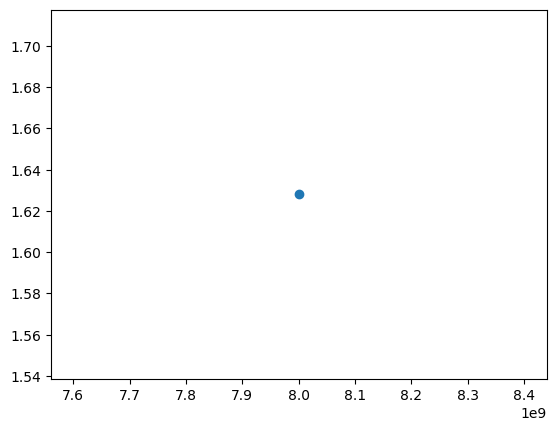

In [7]:
h_freq_FC = paths.cfr(frequencies=FC,
                   normalize=True, # Normalize energy
                   normalize_delays=True,
                   out_type="numpy")

# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_time_steps, num_subcarriers]
print("Shape of h_freq_FC: ", h_freq_FC.shape)
print(np.abs(h_freq_FC)[0,0,0,0,0,0])
plt.scatter(8e9, np.abs(h_freq_FC)[0,0,0,0,0,:])

In [8]:
#h(k,l) => k for tx, l for rx, row is rx, col is tx
h_freq = h_freq_FC.reshape(50,50)
h_freq
U, S, Vh = np.linalg.svd(h_freq)

Shape of a:  (1, 50, 1, 50, 14, 1)
Shape of tau:  (1, 1, 14)


Text(0, 0.5, '$|a|$')

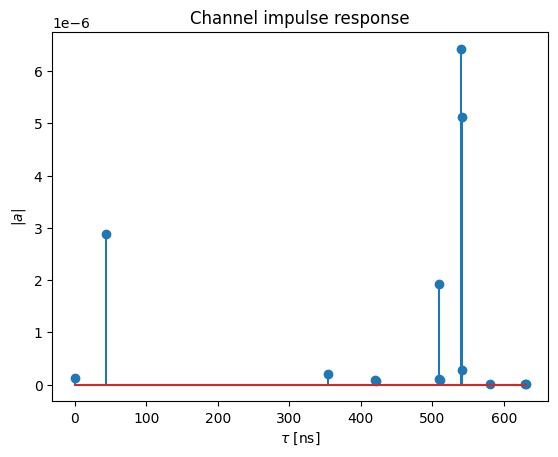

In [9]:
a, tau = paths.cir(normalize_delays=True, out_type="numpy")

# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, num_time_steps]
print("Shape of a: ", a.shape)

# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths]
print("Shape of tau: ", tau.shape)

t = tau[0,0,:]/1e-9 # Scale to ns
a_abs = np.abs(a)[0,0,0,0,:,0]
a_max = np.max(a_abs)

# # And plot the CIR
plt.figure()
plt.title("Channel impulse response")
plt.stem(t, a_abs)
plt.xlabel(r"$\tau$ [ns]")
plt.ylabel(r"$|a|$")

In [10]:
N_PATHS = tau.shape[2]
threshold = find_thresh(S, N_PATHS)
print("threshold: ", threshold)
S_thresh = S[S >= threshold]
rank_h = np.linalg.matrix_rank(h_freq)
rank_h
print(S)
print("numpy rank_h: ", rank_h)
print("my rank_h: ", S_thresh.size)
cond_num = np.linalg.cond(h_freq)
print("condition number: ", cond_num)

threshold:  3.5499395e-06
[4.5593838e+01 2.0205406e+01 3.2086320e+00 1.4105403e+00 6.0393119e-01
 5.0782305e-01 1.7815679e-01 5.6934237e-02 7.1804677e-03 2.5085942e-04
 1.6370277e-05 4.5769648e-06 4.2306010e-06 3.5499395e-06 3.3632932e-06
 3.0465928e-06 2.7885860e-06 2.7263079e-06 2.5191312e-06 2.3729860e-06
 2.2832903e-06 2.1123999e-06 2.0038631e-06 1.9025911e-06 1.7935696e-06
 1.6965407e-06 1.6142737e-06 1.4321298e-06 1.3938205e-06 1.3649855e-06
 1.2596530e-06 1.2160813e-06 1.1267509e-06 1.0626807e-06 9.7729776e-07
 8.8090326e-07 8.1856513e-07 7.7247256e-07 6.8533529e-07 5.9680366e-07
 5.3135767e-07 4.8470275e-07 4.3088161e-07 4.0279647e-07 3.2571754e-07
 2.6592110e-07 2.2417167e-07 1.5664200e-07 1.0297053e-07 4.9597475e-08]
numpy rank_h:  9
my rank_h:  14
condition number:  919277400.0


In [11]:
def create_e(n, delta, omega):
    e = np.empty((n,), dtype = np.complex64)
    for i in range(n):
        e[i] = np.exp(-1j*2*PI*delta*omega*i)
    return e * 1 / np.sqrt(n)

def create_U_P2P(n, delta,):
    U = []
    for i in range(n):
        U.append(create_e(n, delta, i / (n * delta)))
    return np.array(U)

In [12]:
Ut = create_U_P2P(N_TX, D_BY_LAMBDA)
Ur = create_U_P2P(N_RX, D_BY_LAMBDA)
Ha = Ur.conj().T @ h_freq @ Ut
mag_Ha = np.abs(Ha)
# print(mag_Ha[0])
# print(mag_Ha[3])
# print(mag_Ha[48])

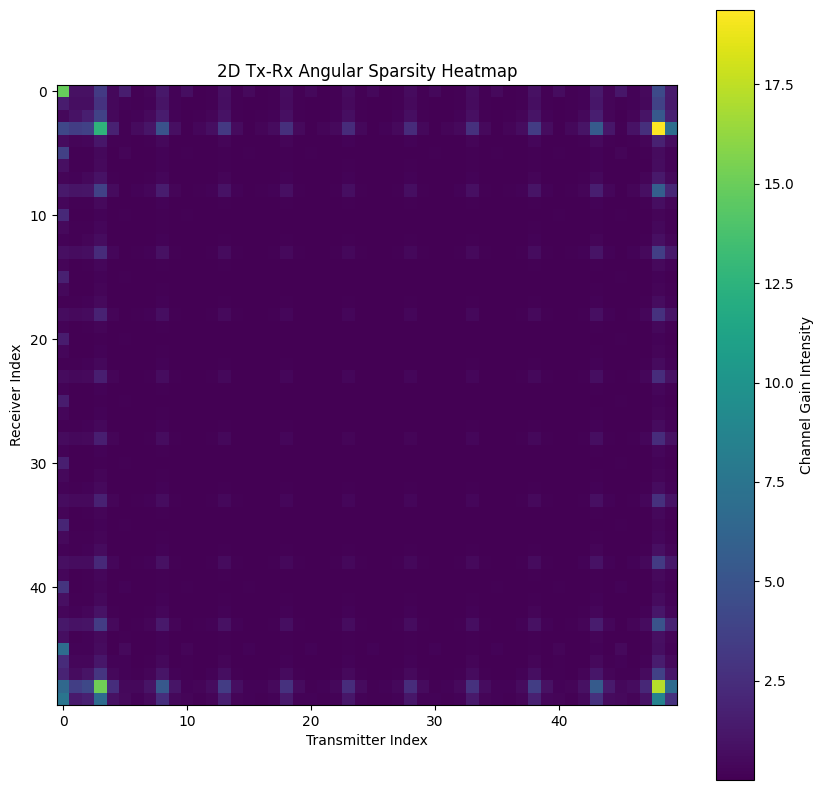

In [13]:
plt.figure(figsize = (10,10))
plt.imshow(mag_Ha)
plt.xlabel("Transmitter Index") #cols
plt.ylabel("Receiver Index") #rows
plt.title("2D Tx-Rx Angular Sparsity Heatmap")
plt.colorbar(label = "Channel Gain Intensity")

In [14]:
tx_bins_kx = np.arange(Ha.shape[1])
rx_bins_ly = np.arange(Ha.shape[0])
tx_bins_kx, rx_bins_ly = np.meshgrid(tx_bins_kx, rx_bins_ly)

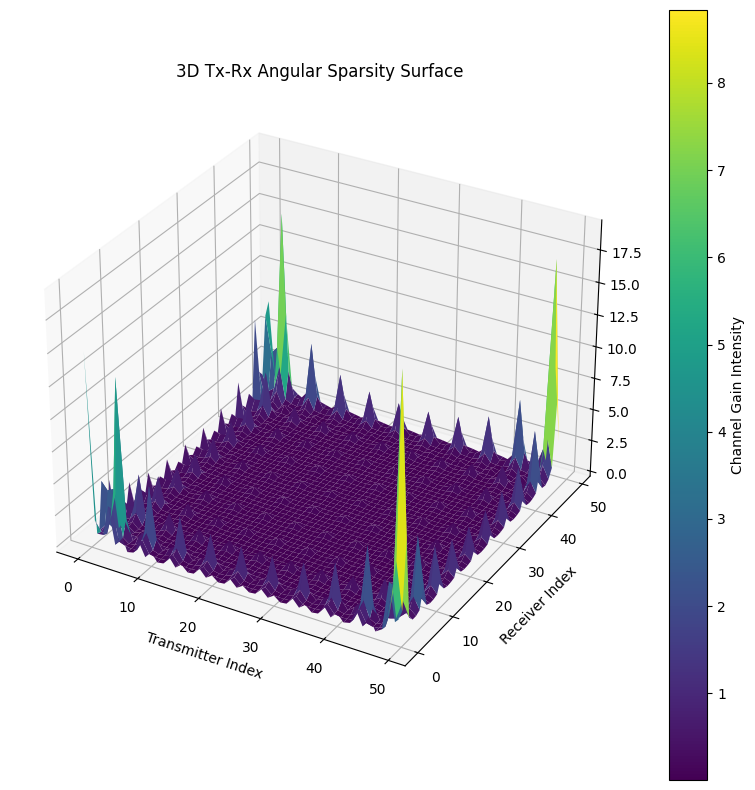

In [15]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection = "3d")
surf = ax.plot_surface(tx_bins_kx, rx_bins_ly, mag_Ha, cmap = "viridis")
ax.set_xlabel("Transmitter Index") #cols
ax.set_ylabel("Receiver Index") #rows
ax.set_title("3D Tx-Rx Angular Sparsity Surface")
fig.colorbar(surf, ax = ax, label = "Channel Gain Intensity")